In [1]:
import pandas as pd

import sqlite3
import pandas as pd

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Create db connection.
cnx = sqlite3.connect('data/database.sqlite')





seasons = ['2015/2016']
leagues_id = [21518]


In [2]:
## Cleaning names of teams

import stringdist

# Normalize names 
def normalize_team_names(y):
    teams = []
    for t in list(y):
        tt = t.lower().split()
        rem = []
        cont=0
        #print(tt)
        for el in tt:
            cont +=1
            if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']: 
                if cont < len(tt):
                    tt[cont]='atl'+tt[cont]
            if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
                rem.append(el)
            
                #print(tt)
        if rem != []:
            for r in rem:
                tt.remove(r)
        
        if len(tt)>1:
            if len(tt[0])>len(tt[1]):
                t = tt[0]
            else:
                t = tt[1]
        else:
            t=tt[0]
        #print(t)  
        teams.append(t)
    return teams

#Change name x for the most similar name in the teams_normalized list.
def func(x,teams_normalized):
    dist =0
    distmin=10
    xt = x.lower().split()
    rem = []
    cont=0
    for el in xt:
        cont +=1
        if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']:
            if cont < len(xt):
                xt[cont]='atl'+xt[cont]
        if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
            rem.append(el)
    if rem != []:
        for r in rem:
                xt.remove(r)
                


    if len(xt)>1:
        if len(xt[0])>len(xt[1]):
            x = xt[0]
        else:
            x = xt[1]
    else:
        x=xt[0]

    
    for t in list(teams_normalized):
        dist = stringdist.levenshtein(x, t)
        #print(t)
        if dist < distmin:
            #print('................')
            #print(x)
            #print(t)
            #print(dist)
            #print('................')
            distmin = dist
            team =t
    return team



def convert_to(df,type_to_convert, all_categorical = False,columns = 'None'):
 
    if all_categorical == True:
        categoric_types = df.select_dtypes(include=['object','category']).columns
        if categoric_types.empty:
            print('No object types in the dataframe to be converted')
            return df
        else:
            if 'labels' in categoric_types:
                categoric_types.remove('labels')
            df[categoric_types] = df[categoric_types].astype('category')
            columns = categoric_types
        
    else:
        df[columns] = df[columns].astype('category')
        
        
    if type_to_convert == 'labelling':
        for column in columns:
            df[column] = df[column].cat.codes
    elif type_to_convert == 'onehot':
        for column in columns:
            print(columns)
            df= pd.get_dummies(df, columns=[column])             
      
    return df

def convert_to_standard_team_names(cnx, league_id, season):

    #.......... df_matches ..........
    
    #Read matches from the season and league specified.
    df_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id = (?) AND season = (?)", cnx, params=(league_id,season,)) 
    print(f'The shape of df_matches of league:{league_id} and season:{season} is: {df_matches.shape}')

    #Drop columns with not useful information (html text), we will get this information from another dataset from football-data.co.uk
    df_matches = df_matches.drop(columns=['goal', 'shoton', 'shotoff','foulcommit', 'card', 'cross', 'corner', 'possession'])

    #Convert types
    df_matches['date'] = pd.to_datetime(df_matches['date'])
    df_matches['date'] = pd.to_datetime(df_matches['date'],format='%Y%m%d')
    df_matches['stage'] = df_matches['stage'].astype(int)
    
   #To merge data with the other dataset we need a common team id between both datasets. We are going to create a unique string identifier for team names named team_name_id.
    
    
    #In the df_matches we will first include a column with the name of the team extracted from the Team table by means of the team_api_id.
    df_Teams = pd.read_sql_query("SELECT * FROM Team ", cnx)
    df_Teams.head()
    

    # Manually change some names due its difficulty to be treated for our string name procedure.
    df_Teams.loc[df_Teams['team_long_name']=='Athletic Club de Bilbao','team_long_name'] = 'Athletic Bilbao'
    df_Teams.loc[df_Teams['team_long_name']=='Real Sporting de Gijón','team_long_name'] = 'Sporting Gijon'
    
    df_Teams.loc[df_Teams['team_long_name']=='West Bromwich Albion','team_long_name'] = 'West Brom'
    df_Teams.loc[df_Teams['team_long_name']=='West Ham United','team_long_name'] = 'West Ham'
    df_Teams.loc[df_Teams['team_long_name']=='Queens Park Rangers','team_long_name'] = 'QPR'
    df_Teams.loc[df_Teams['team_long_name']=='Stoke City','team_long_name'] = 'Stoke'
    df_Teams.loc[df_Teams['team_long_name']=='Hull City','team_long_name'] = 'Hull'
    df_Teams.loc[df_Teams['team_long_name']=='Bolton Wanderers','team_long_name'] = 'Bolton'
    df_Teams.loc[df_Teams['team_long_name']=='Wolverhampton Wanderers', 'team_long_name'] = 'Wolves'
    
    
    
    
    #First we normalize the names of the teams
    teams_normalized = normalize_team_names(df_Teams['team_long_name'])
    
    #Now we normalize the names of df_Teams 
    df_Teams['team_name_id']= df_Teams['team_long_name'].apply(lambda x: func(x,teams_normalized))

    
    #Now we will have to include names of the teams into de df_matches dataframe, for this we have to merge df_matches with df_Teams on the "team_api_id".
    #Since df_matches just have names of the 'home_team_api_id' and 'away_team_api_id', we will add a new column referring the corresponding teams as 'home_team_name_id' and 'away_team_name_id'.
    df_matches['home_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='home_team_api_id', right_on='team_api_id',how='left')['team_name_id']
    df_matches['away_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='away_team_api_id', right_on='team_api_id',how='left')['team_name_id']

    #We finally have the df_matches with the Match Table information but with the home_tema_name_id and away_team_name_id which will be useful to create a common id between the two csv that we want to merge.
    
    #print(df_Teams)
    

    
    #.......... footballdata ..........
    
    #Read matches from the season and league specified.
    location_to_file = 'data/'
    season_footdata = season.replace('/','_').replace('20','') 
    df_footballdata = pd.read_csv(location_to_file+'{0}_{1}.csv'.format(league_id,season_footdata))   
    print(f'The shape of df_footballdata of league:{league_id} and season:{season_footdata} is: {df_footballdata.shape}')
  
    #Convert types    
    df_footballdata['date'] = pd.to_datetime(df_footballdata['Date'])
    df_footballdata['date'] = pd.to_datetime(df_footballdata['date'], format='%Y%m%d')

    
    #Creating same names for teams as the other dataset
    df_footballdata['home_team_name_id'] = df_footballdata['HomeTeam'].apply(lambda x: func(x,teams_normalized))
    df_footballdata['away_team_name_id'] = df_footballdata['AwayTeam'].apply(lambda x: func(x,teams_normalized))
    
    
    
    
    #Creating common match identifier for both datasets (uid)
    df_footballdata['uid']= df_footballdata['home_team_name_id']+df_footballdata['away_team_name_id']
    df_matches['uid']= df_matches['home_team_name_id']+df_matches['away_team_name_id']
    
    return df_matches, df_footballdata

def merge_matchtable_footballdata(season,league_id):
    
    df_matches, df_footballdata = convert_to_standard_team_names(cnx, league_id, season)
    
#     print((df_matches[['home_team_name_id','away_team_name_id','uid']]))
     
#     print((df_footballdata[['home_team_name_id','away_team_name_id']]))

#     print((df_matches['uid'].sort_values(ascending=True)))
#     print((df_footballdata['uid'].sort_values(ascending=True)))
    
    if len(set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid']))) > 0:
        print('Names of uid of both datasets do not match.')
        print('CAUTION!!!! THE FOLLOWING NAMES HAVE DIFFERENT SPELLING IN THE TWO DATASETS: ',
              set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid'])))
    
    # Merging both datasets
    df_complete_league_year = pd.merge(df_matches, df_footballdata[['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR','uid']], on='uid', how='inner')
    
    print(f'df_complete_league_year shape: {df_complete_league_year.shape}')

    
    
    # Implementing models with Real Data as the guys from Stanford suggest.
    # We create the dataset as it is stated at: 
    # *Shin, JongHo and Robert Gasparyan. “A novel way to Soccer Match Prediction.” (2014).*
    
    #Sort per date.
    df_complete_league_year['date'] = pd.to_datetime(df_complete_league_year['date'])
    df_complete_league_year=df_complete_league_year.sort_values(by='date')

    #We keep just the data need it for this.
    df_matches_info = df_complete_league_year[['id','uid','date','stage','home_team_name_id','away_team_name_id','FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR']]  
    df_matches_info[['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']] = df_matches_info.loc[:,['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']].astype(float)

    
    #Creating a column for the labels
    labels = df_matches_info["FTR"]
    df_matches_info = pd.get_dummies(df_matches_info, columns=["FTR", "HTR"])
    df_matches_info['labels'] = labels

    
    #Selecting features
    df_matches_infos = df_matches_info[['id','stage','date','home_team_name_id','away_team_name_id','labels','FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']]
    df_matches_infos = df_matches_info[['id','stage','date','home_team_name_id','away_team_name_id','labels','FTHG', 'FTAG']]

   
    return df_matches_infos


datasets = []
for league_id in leagues_id:
    for season in seasons:
        dataset_season = merge_matchtable_footballdata(season,league_id)
        datasets.append(dataset_season.loc[:, :])
        
df_clustering = pd.concat(datasets)

The shape of df_matches of league:21518 and season:2015/2016 is: (380, 115)
The shape of df_footballdata of league:21518 and season:15_16 is: (380, 64)
df_complete_league_year shape: (380, 128)


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


# Until here we have the origin dataset from which we are going to make the clustering


In [3]:
df_clustering.head()

,id,stage,date,home_team_name_id,away_team_name_id,labels,FTHG,FTAG
2,24180,1,2015-08-21,málaga,sevilla,D,0.0,0.0
1,24179,1,2015-08-22,atlmadrid,palmas,H,1.0,0.0
5,24183,1,2015-08-22,espanyol,getafe,H,1.0,0.0
8,24186,1,2015-08-22,coruña,sociedad,D,0.0,0.0
9,24187,1,2015-08-22,vallecano,valencia,D,0.0,0.0


# Creation of the df where the value between teams is going to be our decision value to make clustering

In [4]:
name_teams = set(df_clustering['home_team_name_id'])

df = pd.DataFrame(columns=name_teams, index= name_teams)
df.head()


,espanyol,celta,betis,atlbilbao,coruña,madrid,palmas,getafe,sociedad,gijon,málaga,valencia,eibar,atlmadrid,barcelona,levante,vallecano,granada,sevilla,villarreal
espanyol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
celta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
betis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
atlbilbao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coruña,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying t

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, espanyol to villarreal
Data columns (total 20 columns):
espanyol      20 non-null category
celta         20 non-null category
betis         20 non-null category
atlbilbao     20 non-null category
coruña        20 non-null category
madrid        20 non-null category
palmas        20 non-null category
getafe        20 non-null category
sociedad      20 non-null category
gijon         20 non-null category
málaga        20 non-null category
valencia      20 non-null category
eibar         20 non-null category
atlmadrid     20 non-null category
barcelona     20 non-null category
levante       20 non-null category
vallecano     20 non-null category
granada       20 non-null category
sevilla       20 non-null category
villarreal    20 non-null category
dtypes: category(20)
memory usage: 5.2+ KB
None
Index(['espanyol', 'celta', 'betis', 'atlbilbao', 'coruña', 'madrid', 'palmas',
       'getafe', 'sociedad', 'gijon', 'málaga', 'valencia',

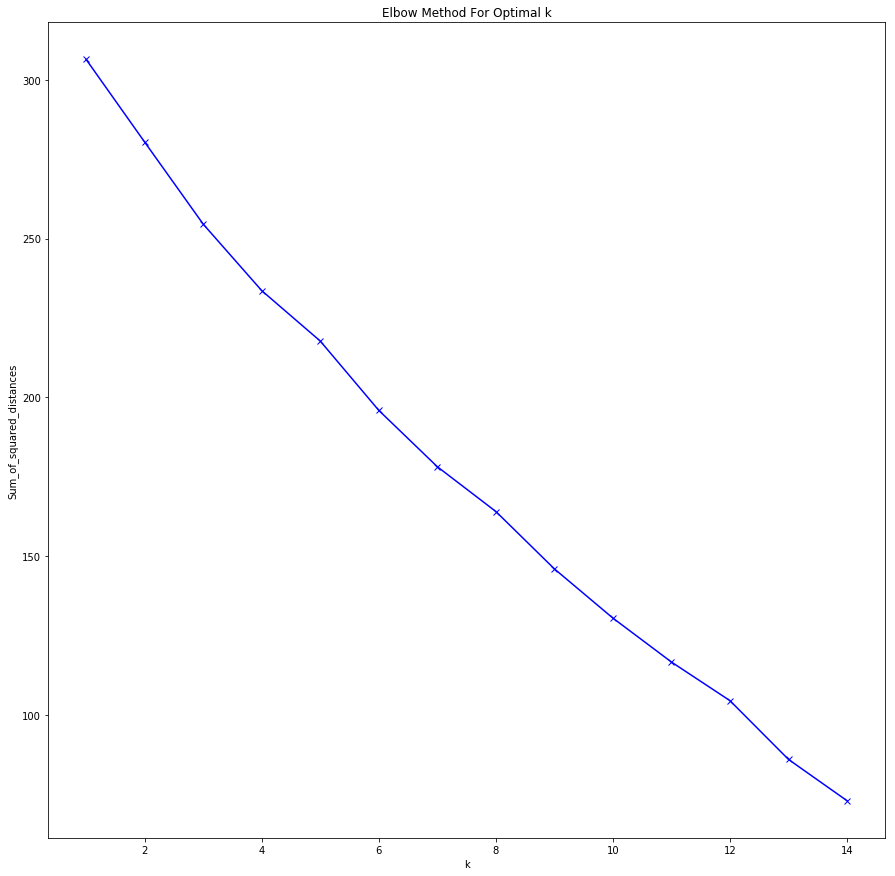

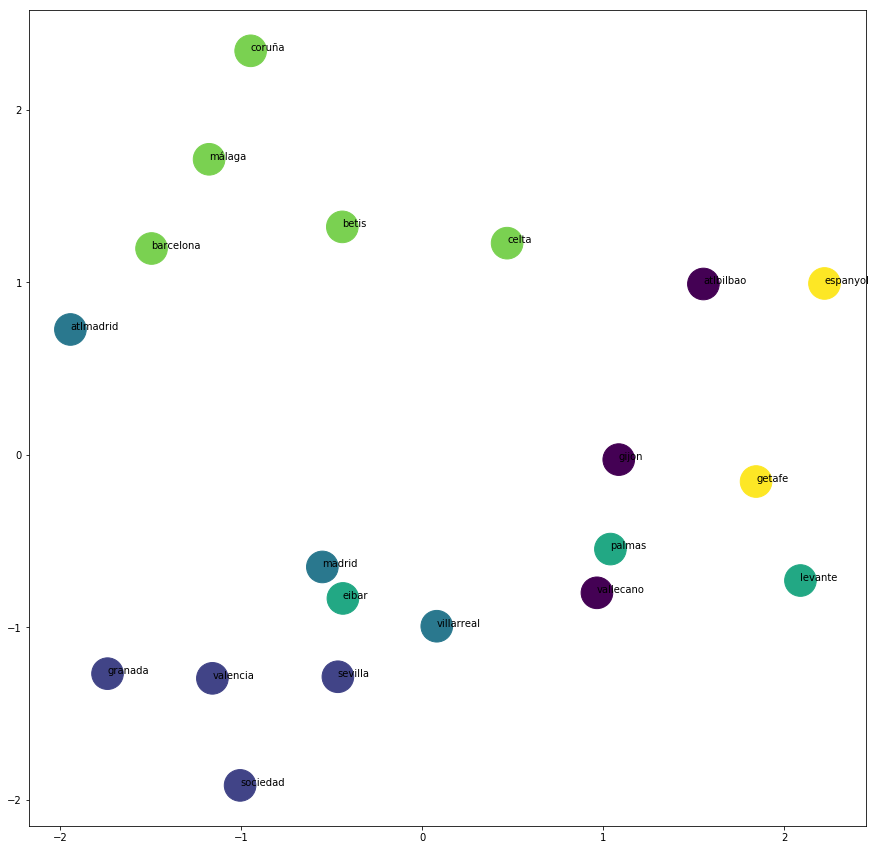

     team_away  cluster_team_away team_home cluster_team_home
0     espanyol                  5       NaN               NaN
1        celta                  4       NaN               NaN
2        betis                  4       NaN               NaN
3    atlbilbao                  0       NaN               NaN
4       coruña                  4       NaN               NaN
5       madrid                  2       NaN               NaN
6       palmas                  3       NaN               NaN
7       getafe                  5       NaN               NaN
8     sociedad                  1       NaN               NaN
9        gijon                  0       NaN               NaN
10      málaga                  4       NaN               NaN
11    valencia                  1       NaN               NaN
12       eibar                  3       NaN               NaN
13   atlmadrid                  2       NaN               NaN
14   barcelona                  4       NaN               NaN
15     l

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, espanyol to villarreal
Data columns (total 20 columns):
espanyol      20 non-null category
celta         20 non-null category
betis         20 non-null category
atlbilbao     20 non-null category
coruña        20 non-null category
madrid        20 non-null category
palmas        20 non-null category
getafe        20 non-null category
sociedad      20 non-null category
gijon         20 non-null category
málaga        20 non-null category
valencia      20 non-null category
eibar         20 non-null category
atlmadrid     20 non-null category
barcelona     20 non-null category
levante       20 non-null category
vallecano     20 non-null category
granada       20 non-null category
sevilla       20 non-null category
villarreal    20 non-null category
dtypes: category(20)
memory usage: 5.2+ KB
None
Index(['espanyol', 'celta', 'betis', 'atlbilbao', 'coruña', 'madrid', 'palmas',
       'getafe', 'sociedad', 'gijon', 'málaga', 'valencia',

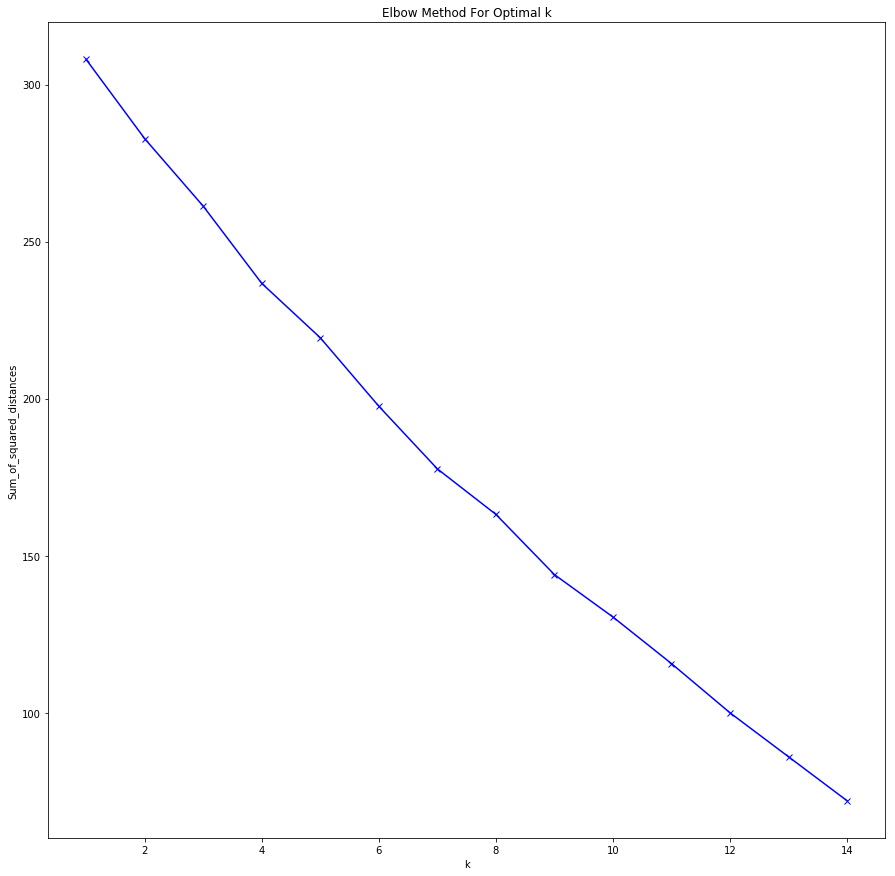

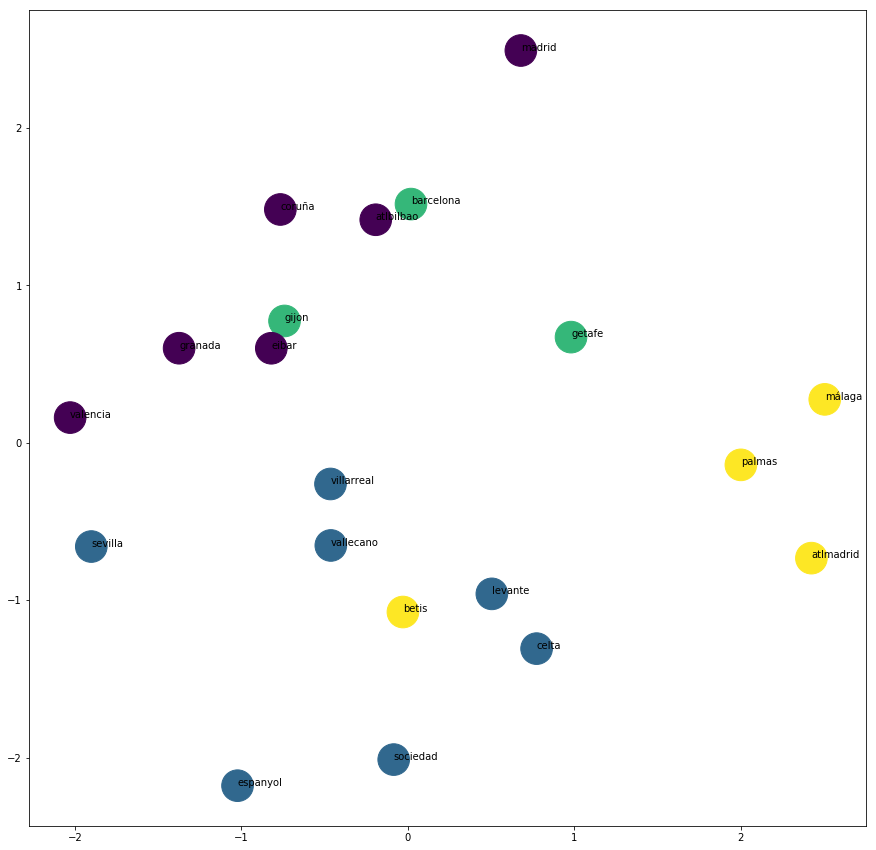

     team_away  cluster_team_away team_home cluster_team_home
0     espanyol                  5       NaN               NaN
1        celta                  4       NaN               NaN
2        betis                  4       NaN               NaN
3    atlbilbao                  0       NaN               NaN
4       coruña                  4       NaN               NaN
5       madrid                  2       NaN               NaN
6       palmas                  3       NaN               NaN
7       getafe                  5       NaN               NaN
8     sociedad                  1       NaN               NaN
9        gijon                  0       NaN               NaN
10      málaga                  4       NaN               NaN
11    valencia                  1       NaN               NaN
12       eibar                  3       NaN               NaN
13   atlmadrid                  2       NaN               NaN
14   barcelona                  4       NaN               NaN
15     l

In [5]:
first_clustering = 5



for i in range(2):
    print(i)
    if i == 0:    
        for team in name_teams:
            df_clustering_teams =df_clustering.loc[df_clustering['home_team_name_id']== team,:]


            ## Remove Rows With Missing Values
            df_clustering_teams.dropna(inplace=True)

            #Remove labels and also the columns that we don't want to use as clustering info
            away_teams =df_clustering_teams['away_team_name_id']
            df_clustering_teams = df_clustering_teams.drop(columns= ['stage','labels','date','id','home_team_name_id','away_team_name_id'])


            #Clustering. We use K =5 because we want to distinct between(H+,H,D,A,A+)
            kmeans = KMeans(n_clusters=first_clustering, random_state=111)
            kmeans.fit(df_clustering_teams)


            #Plotting clustering in pca2 dimensions
            pca = PCA(n_components=2).fit(df_clustering_teams)
            pca_2d = pca.transform(df_clustering_teams)

        #     fig, ax = plt.subplots(figsize=(15,15))
        #     fig.suptitle(f'Home Team: {team}', fontsize=16)
        #     ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)
        #     for i, txt in enumerate(away_teams):
        #         ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))


            df_clust = pd.DataFrame(columns=['team_away','cluster_labels'])
            df_clust['team_away']= away_teams
            df_clust['cluster_labels']= kmeans.labels_

            #Filling our df with the values we want to use for clustering. In this particular case this values come from a previous clustering.
            for away_team in away_teams:
                df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()



        #Fill NaN values due to teams playing to themselves, or due to first match day.
        df =df.fillna('unknown')

        #We should now transpose the matrix to have as a columns the "performance calculated" of the team in the row playing away against the team in the column playing at home.
        dfT= df.T

        dfT =dfT.astype('category')

        print(dfT.info())

        dfT = convert_to(dfT,'onehot', all_categorical = True,columns = 'None')

        dfT.info()  

        #Now we make the clustering for those rows. This clustering wants to cluster teams that have same caracteristics playing away.
        name_teams = set(dfT.index)



        Sum_of_squared_distances = []
        K = range(1,15)
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(dfT)
            Sum_of_squared_distances.append(km.inertia_)

        fig, ax = plt.subplots(figsize=(15,15))    
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()


        kmeans = KMeans(n_clusters=6, random_state=111)
        kmeans.fit(dfT)

        pca = PCA(n_components=2).fit(dfT)
        pca_2d = pca.transform(dfT)

        fig, ax = plt.subplots(figsize=(15,15))
        ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)
        

        for i, txt in enumerate(name_teams):
            ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))
    
        plt.show()
        

        df_cluster = pd.DataFrame(columns=['team_away','cluster_team_away','team_home','cluster_team_home'])
        df_cluster['team_away']= dfT.index
        df_cluster['cluster_team_away']= kmeans.labels_ 
        print(df_cluster)


    elif i ==1:
        for team in name_teams:
            df_clustering_teams =df_clustering.loc[df_clustering['away_team_name_id']== team,:]


            ## Remove Rows With Missing Values
            df_clustering_teams.dropna(inplace=True)

            #Remove labels and also the columns that we don't want to use as clustering info
            away_teams =df_clustering_teams['home_team_name_id']
            df_clustering_teams = df_clustering_teams.drop(columns= ['stage','labels','date','id','home_team_name_id','away_team_name_id'])


            #Clustering. We use K =5 because we want to distinct between(H+,H,D,A,A+)
            kmeans = KMeans(n_clusters=first_clustering, random_state=111)
            kmeans.fit(df_clustering_teams)


            #Plotting clustering in pca2 dimensions
            pca = PCA(n_components=2).fit(df_clustering_teams)
            pca_2d = pca.transform(df_clustering_teams)

        #     fig, ax = plt.subplots(figsize=(15,15))
        #     fig.suptitle(f'Home Team: {team}', fontsize=16)
        #     ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)
        #     for i, txt in enumerate(away_teams):
        #         ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))


            df_clust = pd.DataFrame(columns=['team_away','cluster_labels'])
            df_clust['team_away']= away_teams
            df_clust['cluster_labels']= kmeans.labels_

            #Filling our df with the values we want to use for clustering. In this particular case this values come from a previous clustering.
            for away_team in away_teams:
                df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()



        #Fill NaN values due to teams playing to themselves, or due to first match day.
        df =df.fillna('unknown')

        #We should now transpose the matrix to have as a columns the "performance calculated" of the team in the row playing away against the team in the column playing at home.
        dfT= df.T

        dfT =dfT.astype('category')

        print(dfT.info())

        dfT = convert_to(dfT,'onehot', all_categorical = True,columns = 'None')

        dfT.info()  

        #Now we make the clustering for those rows. This clustering wants to cluster teams that have same caracteristics playing away.
        name_teams = set(dfT.index)



        Sum_of_squared_distances = []
        K = range(1,15)
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(dfT)
            Sum_of_squared_distances.append(km.inertia_)

        fig, ax = plt.subplots(figsize=(15,15))    
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()


        kmeans = KMeans(n_clusters=4, random_state=111)
        kmeans.fit(dfT)

        pca = PCA(n_components=2).fit(dfT)
        pca_2d = pca.transform(dfT)

        fig, ax = plt.subplots(figsize=(15,15))
        ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)

        for i, txt in enumerate(name_teams):
            ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))
            
            
        plt.show()

        print(df_cluster)

        df_cluster['team_home']= dfT.index
        df_cluster['cluster_team_home']= kmeans.labels_   
        print(df_cluster)


In [6]:
df_cluster

,team_away,cluster_team_away,team_home,cluster_team_home
0,espanyol,5,espanyol,1
1,celta,4,celta,1
2,betis,4,betis,3
3,atlbilbao,0,atlbilbao,0
4,coruña,4,coruña,0
5,madrid,2,madrid,0
6,palmas,3,palmas,3
7,getafe,5,getafe,2
8,sociedad,1,sociedad,1
9,gijon,0,gijon,2


# Let's see if this cluster information alone can give us any useful information


In [7]:
df_clustering.head()
df_testing_clustering = df_clustering[['labels','home_team_name_id','away_team_name_id','date']]

In [8]:
def include_cluster_away(team_away,df_cluster):
    clus_away = df_cluster.loc[df_cluster['team_away']==team_away, 'cluster_team_away'].item()
    return clus_away

In [9]:
def include_cluster_home(team_home,df_cluster):
    clus_home = df_cluster.loc[df_cluster['team_home']==team_home, 'cluster_team_home'].item()
    return clus_home

In [10]:
df_testing_clustering['cluster_team_away'] = df_testing_clustering.apply(lambda x: include_cluster_away(x['away_team_name_id'], df_cluster), axis =1 )


df_testing_clustering['cluster_team_home'] = df_testing_clustering.apply(lambda x: include_cluster_home(x['home_team_name_id'], df_cluster), axis =1 )


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
df_testing_clustering.head()

,labels,home_team_name_id,away_team_name_id,date,cluster_team_away,cluster_team_home
2,D,málaga,sevilla,2015-08-21,1,3
1,H,atlmadrid,palmas,2015-08-22,3,3
5,H,espanyol,getafe,2015-08-22,5,1
8,D,coruña,sociedad,2015-08-22,1,0
9,D,vallecano,valencia,2015-08-22,1,1


In [12]:
seasons_data = []
for season in seasons:
    seasons_data.append(season.replace('/','_').replace('20',''))

location_to_file = 'data/'
df_testing_clustering.to_csv(location_to_file+f'df_testing_clustering_app4_{leagues_id}_seasons_{seasons_data}.csv',index=False)

In [13]:
df_clustering.head()
#df_clustering = df_clustering.drop(columns= ['home_team_name_id','away_team_name_id','id','stage'])
df_clustering = df_clustering.drop(columns= ['home_team_name_id','away_team_name_id'])
#df_clustering['dif_goals'] = df_clustering['FTHG']-df_clustering['FTAG']


In [14]:
df_clustering.to_csv(location_to_file+f'df_FTHG_FTAG_{leagues_id}_seasons_{seasons_data}.csv',index=False)

In [15]:
df_clustering.head()

,id,stage,date,labels,FTHG,FTAG
2,24180,1,2015-08-21,D,0.0,0.0
1,24179,1,2015-08-22,H,1.0,0.0
5,24183,1,2015-08-22,H,1.0,0.0
8,24186,1,2015-08-22,D,0.0,0.0
9,24187,1,2015-08-22,D,0.0,0.0


TypeError: unsupported operand type(s) for *: 'float' and 'Timestamp'

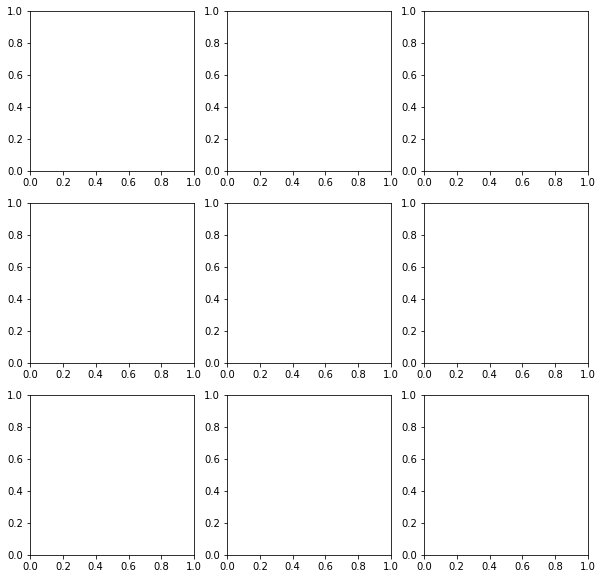

In [16]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(10, 10))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_clustering, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc), size=12)
    ax.axis('off')

fig1.tight_layout()